In [3]:
%load_ext autoreload
%autoreload 2

import sys
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import imagej
import copy
import torch
import cupy as cp
import re
from PIL import Image

import attiicc as ac
from attiicc import SamSegmenter, NanoExperiment

# OLD things:
#sys.path.append('/home/ecdyer/PROJECTS/nanowell_processing/ATTIICC/')
# os.environ['CLASSPATH'] = "/home/ecdyer/Desktop/ImageJ/ij.jar"
# ij = imagej.init('/home/ecdyer/Desktop/ImageJ')
# from jpype import JPackage
# Imglib2 = JPackage('net.imglib2')
# FinalInterval = Imglib2.FinalInterval

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'attiicc' from '/home/ecdyer/PROJECTS/nanowell_processing/ATTIICC/attiicc/__init__.py'>

## Segmenting and Identifying Nanowells in Time Series Datasets

### Segmenting Individual Images for Quality Control

The SamSegmenter class allows you to segment and analyze a single image. It is beneficial to analyze a few individual images prior to running an entire experiment, to ensure that the segmentation parameters are appropriate for your images. The most critical parameter to determine from a single image is the `area_filter`. <br><br>
The area filter is a list of two integers, the first index [0] represents the area of the smallest possible region of interest that will be selected from all segmented images and the second index [1] represents the area of the largest possible region of interest that will be selected from all segmented images. The area filter is used to remove regions of interest that are too small or too large to be a nanowell and are most likely cells that the Segment Anything Model has detected. The SamSegmenter class provides the ability to view the area of all identified regions of interest as well as visualize the masks produced by the segmentation model. <br><br>
To load an individual image you need to define the `model_path` and the `png_path`.
- `model_path` = the SAM you want to use to segment the image. This must be downloaded to the machine you're using for analysis. The models are too large to host on Github, but can be downloaded from the [Segment Anything Model](https://github.com/facebookresearch/segment-anything?tab=readme-ov-file#model-checkpoints). Once you download the model, you need to define the path to the model in the `model_path` variable.
- 'png_path' = the path to the individual image you want to analyze. If images are in TIF format, these can be converted to PNG using the `tif_to_png` function in the `experiment_utils` module (see below).

In [ ]:
# Convert TIF image to PNG (if needed)
tif_path = 'path/to/image.tif'
png_path = ac.utils.convert_tif_to_png(tif_path=tif_path)

# This will save the image at the same location as the TIF file, now as a png, or you can specify 
# where to save the png by using the png_path argument.

To segment an image with SAM, define the model path and the png_path and create a SamSegmenter object.

In [ ]:
image_path = "/media/ss4tbSSD/EDYER/nanowell_processing/images/p00_0_A01f00d0_2.png"
weights = "/media/ss4tbSSD/EDYER/nanowell_processing/weights/sam_vit_h_4b8939.pth"

test_sam = SamSegmenter(weights, png_path=image_path)

To view the segmentation, use the `plot_segmented_image()` function. This will plot the source image and the segmentation mask overlayed on top of the source image. To view the individual masks produced by SAM, use the `plot_mask()` function, which will return a plot with each of the masks individually plotted over the area of the source image. 

In [ ]:
segment_img_save = "/media/ss4tbSSD/EDYER/nanowell_processing/sam_test_segment.png"
masks_img_save = "/media/ss4tbSSD/EDYER/nanowell_processing/sam_test_masks.png"

test_sam.plot_segmented_image(save_path=segment_img_save)
test_sam.plot_masks(save_path=masks_img_save)

Next, individual ROIs and an ROI archive (.zip) file for all segmentations can be created with `generate_rois()`. Notable parameters include:
- The `roi_path` specifies the path where ROIs will be saved. If an `roi_path` is not specified, then ROIs will not be saved. <br><br>

- `filter_distance` and `target_area` are incredibly important for the accuracy of nanowell segmentation across time points. The `filter_distance` is the minimum distance to remove a point that is too close to another point. Because SAM is a generalized model that creates segmentations by randomly sampling points across an image, with regularly patterned nanowell images, sometimes SAM will create two masks for the same well. To remove these duplicate masks, set the `filter_distance` to the appropriate number of pixels to remove nearby points. The `target_area` is the area of the nanowell in pixels. This is used to remove any masks that are too small or too large to be a nanowell. Depending on size of your input images, this can vary significantly from experiment to experiment. 
- To save a plot of the centroids of each mask along with their well_id (the numeric label associated with each nanowell that is used to keep track of wells across time points), set `validation_plot` to `True`
- To save an identity matrix of the distance between centroids in a given image, set `save_heatmap` to `True`. This can be helpful for identifying issues with the segmentation.

Filtering for duplicates...
Duplicate ROI found:  (493, 427) (494, 427)
Duplicate ROI found:  (570, 65) (571, 66)
Duplicate ROI found:  (663, 522) (702, 552)
Duplicate ROI found:  (850, 69) (851, 69)
Removing coordinates... {33, 27, 51, 39}
Removing 1 exact duplicates...
Heatmap saved to:  /home/ecdyer/labshare/LL07132018/NanoTry20231211/20X_H2O2_3_hours/ROIS/validation_plots/p00_0_A01f00d0_2_heatmap.png


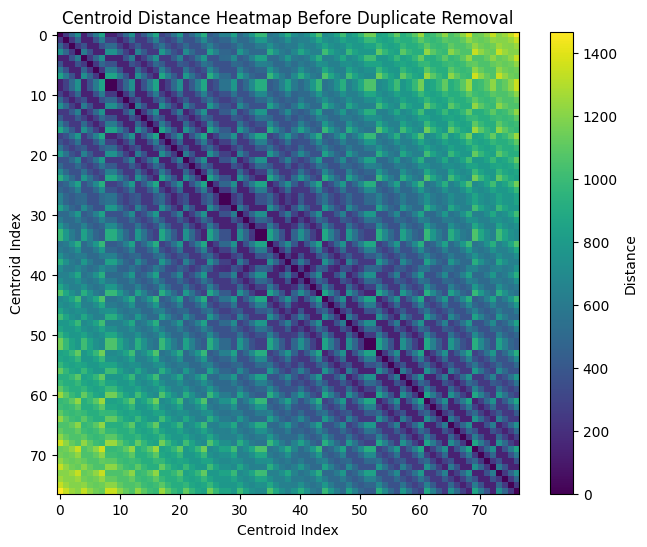

Total number of ROIs:  72
Saving ROIs to:  /home/ecdyer/labshare/LL07132018/NanoTry20231211/20X_H2O2_3_hours/ROIS/p00_0_A01f00d0_2
ROIs saved for p00_0_A01f00d0_2
Archiving ROIs to:  /home/ecdyer/labshare/LL07132018/NanoTry20231211/20X_H2O2_3_hours/ROIS/p00_0_A01f00d0_2_roi.zip
Generating validation plot for  /media/ss4tbSSD/EDYER/nanowell_processing/images/p00_0_A01f00d0_2.png


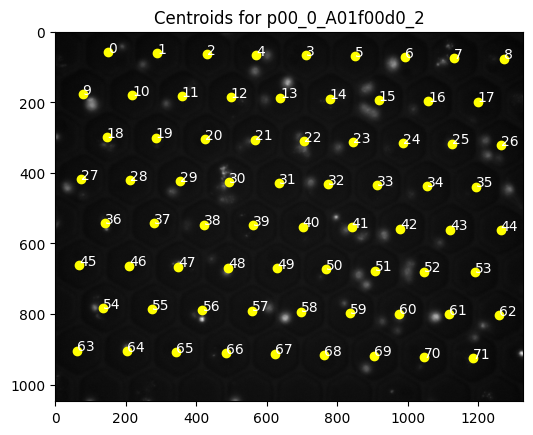

In [ ]:
roi_path = "/home/ecdyer/labshare/LL07132018/NanoTry20231211/20X_H2O2_3_hours/ROIS"
roi, box = test_sam.generate_rois(roi_path=roi_path, 
                                validation_plot=True,
                                filter_distance=50,
                                target_area=[10500,12500], 
                                save_heatmap=True)

To segment an image without reloading SAM, use the `update_image()` function with the existing `SamSegmenter` object. This will update the source image and the segmentation mask.

In [ ]:
# Test changing images without creating a new SamSegmenter object
tif_path = '/media/ss4tbSSD/EDYER/nanowell_processing/images/p15_0_A01f00d3.TIF'
png_path = '/media/ss4tbSSD/EDYER/nanowell_processing/images/p15_0_A01f00d3.png'
test_sam.update_image(png_path, tif_path)

PNG Path:  /media/ss4tbSSD/EDYER/nanowell_processing/images/p15_0_A01f00d3.png


Filtering for duplicates...
Duplicate ROI found:  (65, 905) (66, 905)
Duplicate ROI found:  (65, 905) (66, 905)
Duplicate ROI found:  (499, 188) (499, 189)
Removing coordinates... {0, 1, 29}
Removing 2 exact duplicates...
Heatmap saved to:  /home/ecdyer/labshare/LL07132018/NanoTry20231211/20X_H2O2_3_hours/ROIS/validation_plots/p15_0_A01f00d3_heatmap.png


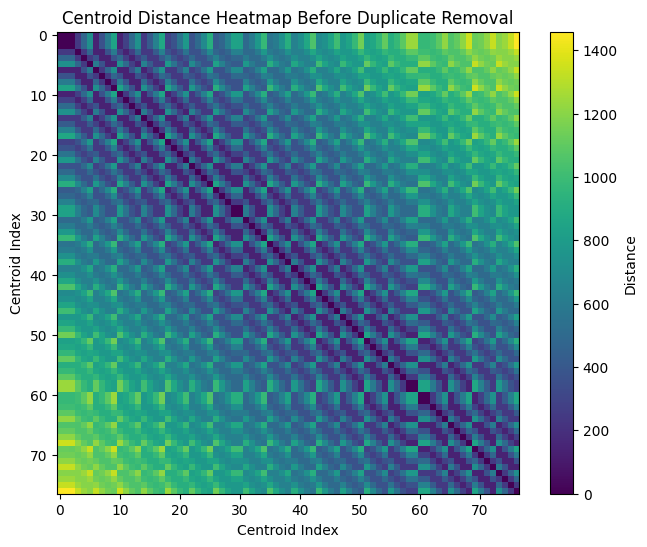

Total number of ROIs:  72
Saving ROIs to:  /home/ecdyer/labshare/LL07132018/NanoTry20231211/20X_H2O2_3_hours/ROIS/p15_0_A01f00d3
ROIs saved for p15_0_A01f00d3
Archiving ROIs to:  /home/ecdyer/labshare/LL07132018/NanoTry20231211/20X_H2O2_3_hours/ROIS/p15_0_A01f00d3_roi.zip
Generating validation plot for  /media/ss4tbSSD/EDYER/nanowell_processing/images/p15_0_A01f00d3.png


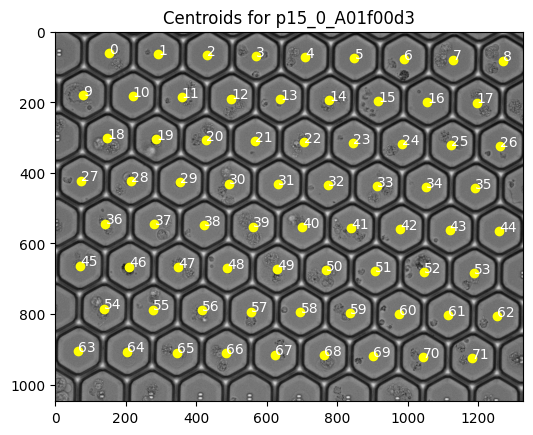

In [ ]:
roi, box = test_sam.generate_rois(roi_path=roi_path, 
                                validation_plot=True,
                                filter_distance=50,
                                target_area=[10500,12500], 
                                save_heatmap=True)

### Segmenting a Whole Experiment of Images

To segment all images in a given experiment, use the `NanoExperiment` class. This requires defining the naming schema. While the naming schema can be defined by the user, the directory structure must be as follows:<br><br>
/path/to/experiment:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/field_id_field_num_channel_id_channel_num:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/img1_timepoint_id_timepoint_num.tif<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/img2_timepoint_id_timepoint_num.tif<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/img3_timepoint_id_timepoint_num.tif<br><br>

Here is an example of a naming schema for a 3-channel experiment with 2 fields and 3 time points:<br><br>
`field_id` = 'f' <br>
`num_fields` = 2 <br>
`channel_id` = 'd' <br>
`num_channels` = 3 <br>
`time_point_id` = 'p' <br>
`num_time_points` = 16 <br>
`segment_channel` = 3 <br><br>
/path/to/experiment:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f00d0<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f01d0/p00.tif<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f01d0/p01.tif<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f01d0/p02.tif<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f00d1<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f01d1/p00.tif<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f01d1/p01.tif<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f01d1/p02.tif<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f00d2<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f01d2/p00.tif<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f01d2/p01.tif<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f01d2/p02.tif<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f01d0<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f01d0/p00.tif<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f01d0/p01.tif<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f01d0/p02.tif<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f01d1<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f01d1/p00.tif<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f01d1/p01.tif<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f01d1/p02.tif<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f01d2<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f01d2/p00.tif<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f01d2/p01.tif<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/path/to/f01d2/p02.tif<br><br>


In [2]:
experiment_path = '/home/ecdyer/PROJECTS/nanowell_processing/test_bad_segmentation'
model_path = "/home/ecdyer/PROJECTS/nanowell_processing/weights/sam_vit_h_4b8939.pth"
field_id = 'f'
num_fields = 2
channel_id = 'd'
num_channels = 4
time_point_id = 'p'
num_time_points = 16
segment_channel = 3

test_exp = NanoExperiment(experiment_path=experiment_path, 
                            field_id=field_id, 
                            num_fields=num_fields,
                            channel_id=channel_id, 
                            num_channels=num_channels, 
                            time_point_id=time_point_id,
                            num_time_points=num_time_points, 
                            segment_channel=segment_channel, 
                            field_leading_zero=True,
                            time_point_leading_zero=True,
                            model_path=model_path,
                            model_type='vit_h')

print(test_exp.structure)

Experiment Structure 
            segment_channel: 3 
            field_id: f 
            field_num: 2 
            field_leading_zero: True 
            channel_id: d 
            channel_num: 4 
            time_point_id: p 
            time_point_num: 16 
            time_point_leading_zero: True


After defining the experiment schema and creating an `NanoExperiment` object, you can segment all images in the experiment using the `segment_experiment()` function. The path to SAM must be present as a parameter in this function, as it will internally initialize a `SamSegmenter` object for every image in the experiment. <br><br>
Additionally, if images are not in PNG format, you can convert them to PNG by setting `convert_png` to `True`. If `conver_png` is false, it will look for PNG images in a directory with the same name as the image folder with '_png' added to the end of the directory name. If this does not exist, there will be an error thrown. <br><br>
Other useful parameters include:<br>
- `generate_rois_params`: this is a dictionary of parameters that will be passed to the `generate_rois()` function. This allows you to set the `roi_path` and `filter_distance` and `target_area` for all images in the experiment. <br>

In [ ]:
model_path = "/home/ecdyer/PROJECTS/nanowell_processing/weights/sam_vit_h_4b8939.pth"
roi_path = "/home/ecdyer/PROJECTS/nanowell_processing/ROIs_bad_segmentation"
well_dict = test_exp.segment_nanowells(model_path=model_path, 
                           convert_png=False,
                           generate_rois_params={'roi_path':roi_path,
                                                 'filter_distance':50,
                                                 'validation_plot':True,
                                                 'save_heatmap':False,
                                                 'target_area':[10500,12500]})

#### Verifying Wells are Correctly Matched Across Time Points
To ensure that wells are correctly matched across time points, the `well_match` parameter in the `generate_rois_params` dictionary can be set to `True`. This will trigger the `match_wells()` function, which will iterate through the well dictionary created by the `segment_nanowells()` function and verify that the location of wells are consistent across images taken at each time point. <br><br>
The `match_wells()` function compares the sum of the coordinates of each ROI's bounding box and if coordinates between adjacent timepoints vary by +/- 10 pixes, the function creates an image with the validation plots of the two adjacent timepoints. The user is the prompted to review the image and has three options for proceeding: 
1. Overwrite ROIs from the second time point with the ROIs from the first time point
2. Overwrite ROIs from the first time point with the ROIs from the second time point
3. Take no action and continue checking other wells


In [5]:
# Define the structure
experiment_path = '/home/ecdyer/PROJECTS/nanowell_processing/test_bad_segmentation'
model_path = "/home/ecdyer/PROJECTS/nanowell_processing/weights/sam_vit_h_4b8939.pth"
field_id = 'f'
num_fields = 2
channel_id = 'd'
num_channels = 1
time_point_id = 'p'
num_time_points = 6
segment_channel = 3

# Initialize the experiment
test_exp = NanoExperiment(experiment_path=experiment_path, 
                            field_id=field_id, 
                            num_fields=num_fields,
                            channel_id=channel_id, 
                            num_channels=num_channels, 
                            time_point_id=time_point_id,
                            num_time_points=num_time_points, 
                            segment_channel=segment_channel, 
                            field_leading_zero=True,
                            time_point_leading_zero=True,
                            model_path=model_path,
                            model_type='vit_h')

# Segment the images (well_match=True)
roi_path = "/home/ecdyer/PROJECTS/nanowell_processing/dev_ROIs"
whole_image_dict, well_dict = test_exp.segment_nanowells(model_path=model_path, 
                           convert_png=False,
                           generate_rois_params={'roi_path':roi_path,
                                                 'filter_distance':50,
                                                 'validation_plot':True,
                                                 'validation_path':'/home/ecdyer/PROJECTS/nanowell_processing/test_bad_segmentation/validation_plots',
                                                 'save_heatmap':False,
                                                 'target_area':[6250, 12500],
                                                 'well_match':False})

CUDA is available.
Number of CUDA devices: 1
Model Loaded
PNG Path:  /home/ecdyer/PROJECTS/nanowell_processing/test_bad_segmentation/f00d3_png/scan_Top Slide_R_p07_0_A01f00d3.png


### Assess Well Segmentation

PNG Image Directory Path:  ['p00_0_A01f00d3.png', 'p10_0_A01f00d3.png', 'p20_0_A01f00d3.png', 'p30_0_A01f00d3.png', 'p40_0_A01f00d3.png', 'p50_0_A01f00d3.png', 'p60_0_A01f00d3.png', 'p70_0_A01f00d3.png', 'p80_0_A01f00d3.png', 'p90_0_A01f00d3.png', 'p100_0_A01f00d3.png', 'p110_0_A01f00d3.png', 'p120_0_A01f00d3.png', 'p130_0_A01f00d3.png', 'p140_0_A01f00d3.png']
CUDA is available.
Number of CUDA devices: 1
Model Loaded
PNG Path:  /home/ecdyer/PROJECTS/nanowell_processing/small_t_cell_test/f00d3_png/p00_0_A01f00d3.png
Total number of ROIs before filtering:  81
Filtering for duplicates...
Initial number of ROIs: 81
Filter distance: 50
Removing exact duplicate centroid at index 21: [410, 985]
Removing exact duplicate centroid at index 30: [550, 986]
Removing exact duplicate centroid at index 44: [759, 867]
Removing exact duplicate centroid at index 49: [829, 988]
Removing exact duplicate centroid at index 55: [899, 869]
Removing exact duplicate centroid at index 60: [968, 989]
Removing exac

ValueError: could not convert string to float: 'N'

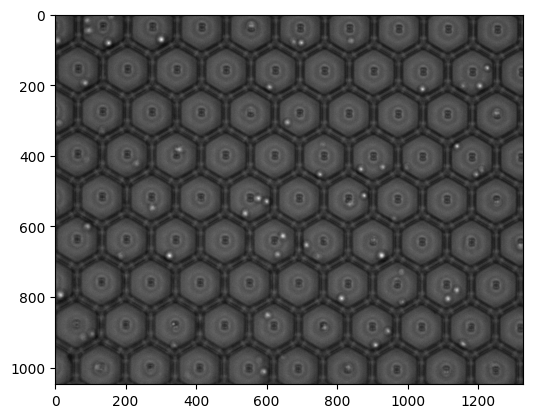

In [10]:
# Define the structure
experiment_path = '/home/ecdyer/PROJECTS/nanowell_processing/small_t_cell_test'
model_path = "/home/ecdyer/PROJECTS/nanowell_processing/weights/sam_vit_h_4b8939.pth"
field_id = 'f'
num_fields = 1
channel_id = 'd'
num_channels = 4
time_point_id = 'p'
num_time_points = 6
segment_channel = 3

# Initialize the experiment
test_exp = NanoExperiment(experiment_path=experiment_path, 
                            field_id=field_id, 
                            num_fields=num_fields,
                            channel_id=channel_id, 
                            num_channels=num_channels, 
                            time_point_id=time_point_id,
                            num_time_points=num_time_points, 
                            segment_channel=segment_channel, 
                            field_leading_zero=True,
                            time_point_leading_zero=True,
                            model_path=model_path,
                            model_type='vit_h')

# Segment the images (well_match=True)
roi_path = "/home/ecdyer/PROJECTS/nanowell_processing/dev_ROIs"
whole_img_dict, well_dict = test_exp.segment_nanowells(model_path=model_path, 
                           convert_png=False,
                           well_location_tolerance = 50, 
                           generate_rois_params={'roi_path':roi_path,
                                                 'filter_distance':50,
                                                 'validation_plot':True,
                                                 'save_heatmap':False,
                                                 'target_area':[9500,12500],
                                                 'filter_duplicates':True,
                                                 'validation_path':'/home/ecdyer/PROJECTS/nanowell_processing/small_t_cell_test/validation_plots',})

In [5]:
print(well_dict.keys())

dict_keys(['f00_well0', 'f00_well1', 'f00_well2', 'f00_well3', 'f00_well4', 'f00_well5', 'f00_well6', 'f00_well7', 'f00_well8', 'f00_well9', 'f00_well10', 'f00_well11', 'f00_well12', 'f00_well13', 'f00_well14', 'f00_well15', 'f00_well16', 'f00_well17', 'f00_well18', 'f00_well19', 'f00_well20', 'f00_well21', 'f00_well22', 'f00_well23', 'f00_well24', 'f00_well25', 'f00_well26', 'f00_well27', 'f00_well28', 'f00_well29', 'f00_well30', 'f00_well31', 'f00_well32', 'f00_well33', 'f00_well34', 'f00_well35', 'f00_well36', 'f00_well37', 'f00_well38', 'f00_well39', 'f00_well40', 'f00_well41', 'f00_well42', 'f00_well43', 'f00_well44', 'f00_well45', 'f00_well46', 'f00_well47', 'f00_well48', 'f00_well49', 'f00_well50', 'f00_well51', 'f00_well52', 'f00_well53', 'f00_well54', 'f00_well55', 'f00_well56', 'f00_well57', 'f00_well58', 'f00_well59', 'f00_well60', 'f00_well61', 'f00_well62', 'f00_well63', 'f00_well64', 'f00_well65', 'f00_well66', 'f00_well67', 'f00_well68', 'f00_well69', 'f00_well70', 'f00_

In [47]:
print(whole_img_dict.keys())
print(whole_img_dict['f01'])
sorted_png_paths = []
png_paths = []
for dictionary in whole_img_dict['f01'][1]:
    path = list(dictionary.keys())[0]
    png_paths.append(path)

print(png_paths)

def sort_paths(paths):
    def extract_number(path):
        # Extract the filename from the path
        filename = path.split('/')[-1]
        # Find the number after 'p' in the filename
        match = re.search(r'p(\d+)', filename)
        # Return the number as an integer, or 0 if not found
        return int(match.group(1)) if match else 0

    # Sort the paths using the extract_number function as key
    return sorted(paths, key=extract_number)

sorted_paths = sort_paths(png_paths)
print(sorted_paths)


dict_keys(['f00', 'f01'])
[[74, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 73], [{'/home/ecdyer/PROJECTS/nanowell_processing/test_T_cell_only_data/f01d3_png/p00_0_A01f01d3.png': {'f01_well0': (1116, 43), 'f01_well1': (1255, 44), 'f01_well2': (69, 149), 'f01_well3': (209, 150), 'f01_well4': (348, 152), 'f01_well5': (488, 152), 'f01_well6': (627, 154), 'f01_well7': (766, 155), 'f01_well8': (905, 156), 'f01_well9': (1045, 157), 'f01_well10': (1185, 158), 'f01_well11': (137, 270), 'f01_well12': (277, 272), 'f01_well13': (417, 273), 'f01_well14': (556, 274), 'f01_well15': (696, 275), 'f01_well16': (835, 276), 'f01_well17': (974, 277), 'f01_well18': (1114, 278), 'f01_well19': (1254, 279), 'f01_well20': (67, 390), 'f01_well21': (207, 392), 'f01_well22': (347, 393), 'f01_well23': (486, 394), 'f01_well24': (625, 395), 'f01_well25': (764, 396), 'f01_well26': (904, 397), 'f01_well27': (1043, 398), 'f01_well28': (1183, 399), 'f01_well29': (136, 512), 'f01_well30': (276, 513), 'f01_well31'

In [27]:
whole_img_dict['f01'][1][0]
keys_list = [list[d.keys()] for d in whole_img_dict['f01'][1]]
print(keys_list)

[dict_keys(['/home/ecdyer/PROJECTS/nanowell_processing/test_T_cell_only_data/f01d3_png/p00_0_A01f01d3.png']), dict_keys(['/home/ecdyer/PROJECTS/nanowell_processing/test_T_cell_only_data/f01d3_png/p20_0_A01f01d3.png']), dict_keys(['/home/ecdyer/PROJECTS/nanowell_processing/test_T_cell_only_data/f01d3_png/p130_0_A01f01d3.png']), dict_keys(['/home/ecdyer/PROJECTS/nanowell_processing/test_T_cell_only_data/f01d3_png/p90_0_A01f01d3.png']), dict_keys(['/home/ecdyer/PROJECTS/nanowell_processing/test_T_cell_only_data/f01d3_png/p100_0_A01f01d3.png']), dict_keys(['/home/ecdyer/PROJECTS/nanowell_processing/test_T_cell_only_data/f01d3_png/p50_0_A01f01d3.png']), dict_keys(['/home/ecdyer/PROJECTS/nanowell_processing/test_T_cell_only_data/f01d3_png/p140_0_A01f01d3.png']), dict_keys(['/home/ecdyer/PROJECTS/nanowell_processing/test_T_cell_only_data/f01d3_png/p60_0_A01f01d3.png']), dict_keys(['/home/ecdyer/PROJECTS/nanowell_processing/test_T_cell_only_data/f01d3_png/p80_0_A01f01d3.png']), dict_keys(['/ho

In [8]:
print(well_dict['f00_well0'])
print()

[[ImagejRoi(
    roitype=ROI_TYPE.FREEHAND,
    options=ROI_OPTIONS.OVERLAY_BACKGROUNDS | ROI_OPTIONS.OVERLAY_LABELS,
    name='70373b81-64af-11ef-8366-3766e889a761',
    version=226,
    top=843,
    left=10,
    bottom=970,
    right=127,
    n_coordinates=186,
    integer_coordinates=numpy.array([
        [ 55,   0],
        [ 54,   1],
        [ 52,   1],
        [ 51,   2],
        [ 50,   2],
        [ 49,   3],
        [ 48,   3],
        [ 47,   4],
        [ 46,   4],
        [ 45,   5],
        [ 43,   5],
        [ 41,   7],
        [ 40,   7],
        [ 39,   8],
        [ 38,   8],
        [ 36,  10],
        [ 35,  10],
        [ 34,  11],
        [ 33,  11],
        [ 32,  12],
        [ 31,  12],
        [ 30,  13],
        [ 29,  13],
        [ 28,  14],
        [ 27,  14],
        [ 25,  16],
        [ 24,  16],
        [ 23,  17],
        [ 22,  17],
        [ 21,  18],
        [ 20,  18],
        [ 19,  19],
        [ 18,  19],
        [ 16,  21],
        [ 15,  21]

In [4]:
print(well_dict['f00_well0'])
print()

[[ImagejRoi(
    roitype=ROI_TYPE.FREEHAND,
    options=ROI_OPTIONS.OVERLAY_BACKGROUNDS | ROI_OPTIONS.OVERLAY_LABELS,
    name='ada84e26-45e9-11ef-82dc-4f920053a76c',
    version=226,
    left=97,
    bottom=126,
    right=213,
    n_coordinates=184,
    integer_coordinates=numpy.array([
        [ 55,   0],
        [ 55,   1],
        [ 54,   2],
        [ 51,   2],
        [ 50,   3],
        [ 47,   3],
        [ 46,   4],
        [ 44,   4],
        [ 43,   5],
        [ 42,   5],
        [ 41,   6],
        [ 40,   6],
        [ 38,   8],
        [ 37,   8],
        [ 36,   9],
        [ 35,   9],
        [ 34,  10],
        [ 33,  10],
        [ 32,  11],
        [ 31,  11],
        [ 29,  13],
        [ 28,  13],
        [ 27,  14],
        [ 26,  14],
        [ 24,  16],
        [ 23,  16],
        [ 22,  17],
        [ 21,  17],
        [ 20,  18],
        [ 19,  18],
        [ 18,  19],
        [ 17,  19],
        [ 16,  20],
        [ 15,  20],
        [ 14,  21],
        [ 1

In [5]:
print(whole_img_dict.keys())

dict_keys(['f00', 'f01'])


In [6]:
print(whole_img_dict['f00'])

{'total_rois': [72], 'png_path': ['/home/ecdyer/PROJECTS/nanowell_processing/small_test_data/f00d3_png/p02_0_A01f00d3.png'], 'first_well_coords': [333]}


In [19]:
ij = imagej.init('sc.fiji:fiji')

# Get help for the "crop" operation directly from ImageJ operations
crop_help = ij.op().help("crop")
print(crop_help)

Available operations:
	(ImgPlus out) =
	net.imagej.ops.transform.crop.CropImgPlus(
		ImgPlus in1,
		Interval in2,
		boolean dropSingleDimensions?)
	(RandomAccessibleInterval out) =
	net.imagej.ops.transform.crop.CropRAI(
		RandomAccessibleInterval in1,
		Interval in2,
		boolean dropSingleDimensions?)


In [ ]:
test_dict = {}